In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

%matplotlib inline

#### PROVIDE DATA

In [51]:
MDATA_PATH = 'sirius_ml_labs-main-ps4-mdata/ps4/mdata/'

full_name = 'Dmitry Polovnikov'
random_state = sum(map(ord,full_name))

In [6]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers(date):
    return sorted(os.listdir(os.path.join(MDATA_PATH,date)))
dates = get_dates()

date_tickers = dict([(date,get_tickers(date)) for date in dates])
tickers = np.unique(np.concatenate(list(date_tickers.values()))).tolist()

def get_market_data(ticker):
    data = []
    for date in dates:
#         print (date)
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        )
        df.drop([
                'TIMESTAMP','WEEKDAY','MINUTE','HOUR','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
                'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','BAR_DURATION'
            ], axis = 1, inplace = True
        )
        df = df[df.columns[~df.columns.str.startswith('EXEC')]]
        data.append(df)
    data = pd.concat(data).set_index('bar_time').sort_index()
    
    price_grid = data.filter(like='PRICE_GRID')
    vol_grid = data.filter(like='VOL_GRID')
    
    data = data[ data.columns[ ~data.columns.str.startswith('PRICE_GRID') & ~data.columns.str.startswith('VOL_GRID') ] ]
    
    return data,price_grid,vol_grid

In [10]:
ticker = 'Z.DOGE'
mdata,pgrid,vgrid = get_market_data(ticker)
mdata = mdata.groupby(mdata.index).last()
returns_ahead = mdata['LAST'].pct_change().shift(-1).fillna(0)
# EXCLUDING NON-STATIONARY DATA HARD-CODED.
mdata.drop(['BEST_BID','BEST_ASK','LAST','HIGH','LOW','VWAP'],axis=1,inplace=True)

/tmp/ipykernel_350072/4197269535.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_350072/4197269535.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_350072/4197269535.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_350072/4197269535.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call

#### DATA ANALYSIS

##### (a) train_test_split

In [11]:
mdata_train,mdata_test,returns_ahead_train,returns_ahead_test = train_test_split(mdata,returns_ahead,test_size=0.2,random_state=random_state)

##### (b) data_transform

In [12]:
# QUANTILE TRANSFORMER
qt = QuantileTransformer(random_state=random_state)
qt.fit(mdata_train)
mdata_train_quantile = qt.transform(mdata_train)
mdata_test_quantile = qt.transform(mdata_test)

<Axes: >

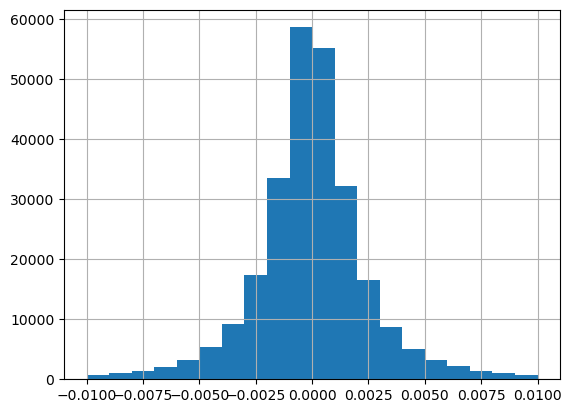

In [13]:
returns_ahead_train[returns_ahead_train.abs()<0.01].hist(bins=20)

In [14]:
sgn_returns_ahead_train = (returns_ahead_train>=0).astype(int)
sgn_returns_ahead_test = (returns_ahead_test>=0).astype(int)

In [16]:
q_returns_ahead_train = (returns_ahead_train>=q075).astype(int)
q_returns_ahead_test = (returns_ahead_test>=q075).astype(int)

In [99]:
from sklearn.preprocessing import StandardScaler

# STANDARD TRANSFORMER
st = StandardScaler()
st.fit(mdata_train)
mdata_train_standard = st.transform(mdata_train)
mdata_test_standard = st.transform(mdata_test)

### DECISION TREES

#### (c) run decision trees, display statistics for train&test 

In [89]:
max_depths = np.logspace(start=0, stop=6, base=2, num=10, dtype=int)[2:]
max_depths

array([ 2,  4,  6, 10, 16, 25, 40, 64])

#### decision tree on quantile transform

In [88]:
dts = dict()

for max_depth in max_depths:
    #print (max_depth)
    dt = DecisionTreeClassifier(max_depth=max_depth,random_state=random_state)
    dt.fit(mdata_train_quantile,sgn_returns_ahead_train)
    dts[max_depth] = dt

accuracies = dict()
for max_depth,dt in dts.items():
    #print (max_depth)
    accuracies[max_depth] = (
        accuracy_score(sgn_returns_ahead_train.values,dt.predict(mdata_train_quantile)),
        accuracy_score(sgn_returns_ahead_test.values,dt.predict(mdata_test_quantile))
    )

              precision    recall  f1-score   support

           0       0.58      0.74      0.65    132964
           1       0.64      0.46      0.54    132620

    accuracy                           0.60    265584
   macro avg       0.61      0.60      0.59    265584
weighted avg       0.61      0.60      0.59    265584



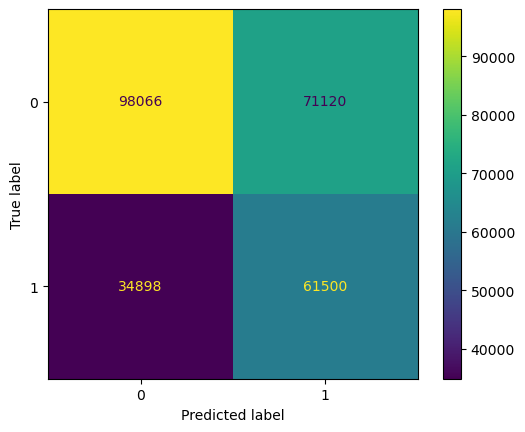

In [93]:
# confusion matrix for train
dt = DecisionTreeClassifier(max_depth=20,random_state=random_state)
dt.fit(mdata_train_quantile, sgn_returns_ahead_train)
answers = dt.predict(mdata_train_quantile)

cm = confusion_matrix(answers, sgn_returns_ahead_train, labels=dt.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=dt.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_train.values,dt.predict(mdata_train_quantile)))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67     33265
           1       0.67      0.66      0.67     33131

    accuracy                           0.67     66396
   macro avg       0.67      0.67      0.67     66396
weighted avg       0.67      0.67      0.67     66396



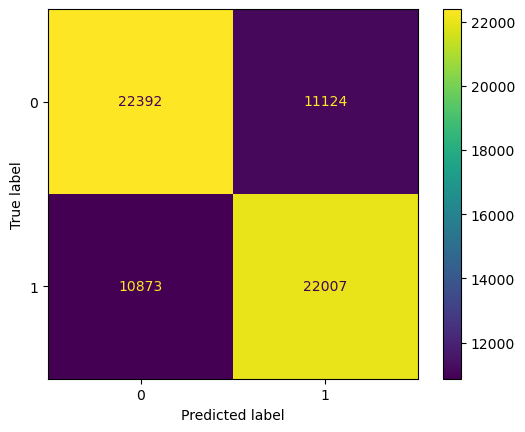

In [96]:
# confusion matrix for test

cm = confusion_matrix(answers, sgn_returns_ahead_test, labels=dt.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=dt.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_test.values,dt.predict(mdata_test_quantile)))

#### decision tree on standard transform

In [100]:
dts = dict()

for max_depth in max_depths:
    #print (max_depth)
    dt = DecisionTreeClassifier(max_depth=max_depth,random_state=random_state)
    dt.fit(mdata_train_standard, sgn_returns_ahead_train)
    dts[max_depth] = dt

accuracies = dict()
for max_depth,dt in dts.items():
    #print (max_depth)
    accuracies[max_depth] = (
        accuracy_score(sgn_returns_ahead_train.values,dt.predict(mdata_train_standard)),
        accuracy_score(sgn_returns_ahead_test.values,dt.predict(mdata_test_standard))
    )

              precision    recall  f1-score   support

           0       0.58      0.74      0.65    132964
           1       0.64      0.46      0.54    132620

    accuracy                           0.60    265584
   macro avg       0.61      0.60      0.59    265584
weighted avg       0.61      0.60      0.59    265584



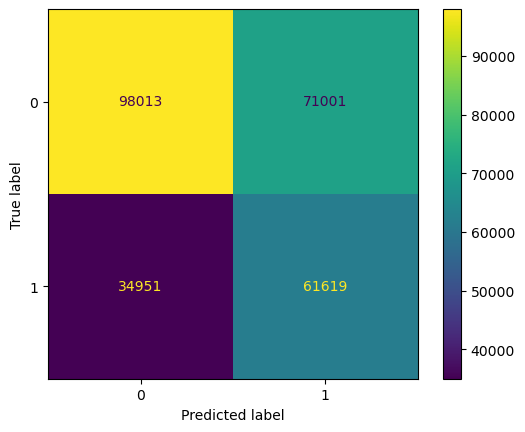

In [101]:
# confusion matrix for train
dt = DecisionTreeClassifier(max_depth=20,random_state=random_state)
dt.fit(mdata_train_standard,sgn_returns_ahead_train)
answers = dt.predict(mdata_train_standard)

cm = confusion_matrix(answers,sgn_returns_ahead_train, labels=dt.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=dt.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_train.values,dt.predict(mdata_train_standard)))

              precision    recall  f1-score   support

           0       0.50      0.64      0.56     33265
           1       0.51      0.37      0.43     33131

    accuracy                           0.50     66396
   macro avg       0.50      0.50      0.50     66396
weighted avg       0.50      0.50      0.50     66396



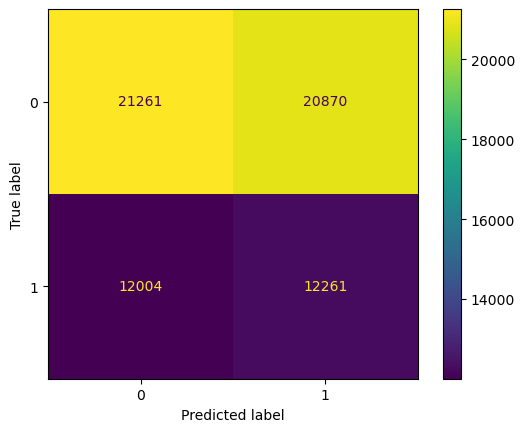

In [102]:
# confusion matrix for test
answers = dt.predict(mdata_test_standard)

cm = confusion_matrix(answers,sgn_returns_ahead_test, labels=dt.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=dt.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_test.values,dt.predict(mdata_test_standard)))

### (c) XGB CLASSIFIER

In [120]:
n_estimators = np.logspace(start=0, stop=10, base=1.3, num=10, dtype=int)[2:]
n_estimators

array([ 1,  2,  3,  4,  5,  7, 10, 13])

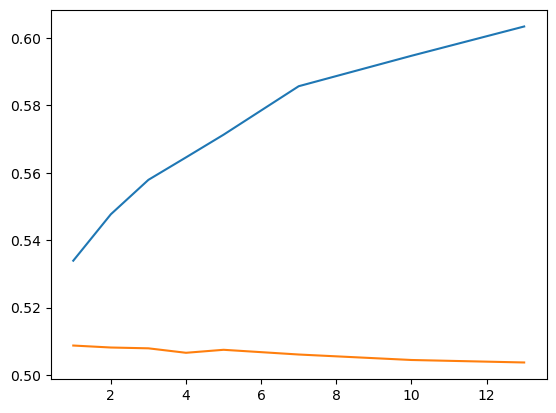

In [121]:
xgs = dict()

for n_est in n_estimators:
    xgb = XGBClassifier(n_estimators=n_est, max_depth=10, random_state=random_state)
    xgb.fit(mdata_train_quantile,sgn_returns_ahead_train)
    xgs[n_est] = xgb
    
accuracies = dict()
for n_est, xgb in xgs.items():
    accuracies[n_est] = (
        accuracy_score(sgn_returns_ahead_train.values, xgb.predict(mdata_train_quantile)),
        accuracy_score(sgn_returns_ahead_test.values, xgb.predict(mdata_test_quantile))
    )
    
plt.plot(n_estimators, accuracies.values())

In [ ]:
# ??? - THERE IS NO IMPROVEMENT FOR ADDITIONAL BOOSTING ROUNDS!

#### quantile transform

              precision    recall  f1-score   support

           0       0.54      0.65      0.59    132964
           1       0.56      0.44      0.49    132620

    accuracy                           0.55    265584
   macro avg       0.55      0.55      0.54    265584
weighted avg       0.55      0.55      0.54    265584



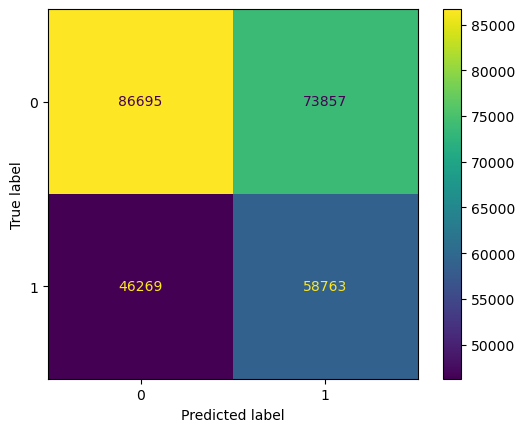

In [127]:
# confusion matrix for train
xgb = XGBClassifier(n_estimators=2, max_depth=10, random_state=random_state)
xgb.fit(mdata_train_quantile,sgn_returns_ahead_train)
answers = xgb.predict(mdata_train_quantile)

cm = confusion_matrix(answers, sgn_returns_ahead_train, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_train.values, xgb.predict(mdata_train_quantile)))

              precision    recall  f1-score   support

           0       0.51      0.61      0.56     33265
           1       0.51      0.40      0.45     33131

    accuracy                           0.51     66396
   macro avg       0.51      0.51      0.50     66396
weighted avg       0.51      0.51      0.50     66396



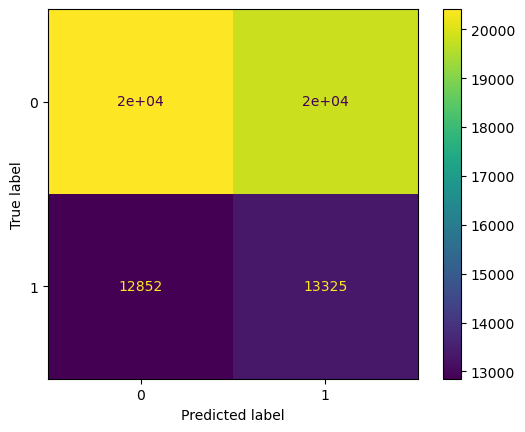

In [128]:
# confusion matrix for test
answers = xgb.predict(mdata_test_quantile)

cm = confusion_matrix(answers, sgn_returns_ahead_test, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_test.values, xgb.predict(mdata_test_quantile)))

#### standard transform

              precision    recall  f1-score   support

           0       0.54      0.65      0.59    132964
           1       0.56      0.45      0.50    132620

    accuracy                           0.55    265584
   macro avg       0.55      0.55      0.54    265584
weighted avg       0.55      0.55      0.54    265584



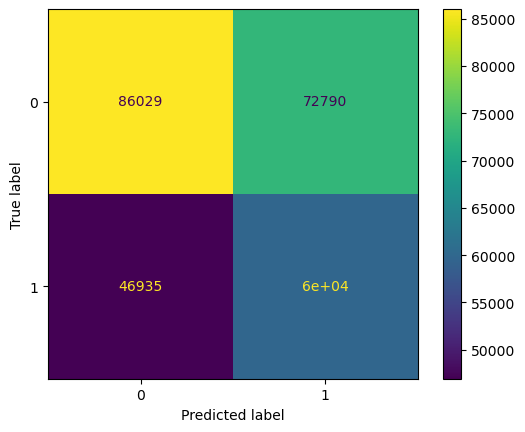

In [131]:
# confusion matrix for train
xgb = XGBClassifier(n_estimators=2, max_depth=10, random_state=random_state)
xgb.fit(mdata_train_standard,sgn_returns_ahead_train)
answers = xgb.predict(mdata_train_standard)

cm = confusion_matrix(answers,sgn_returns_ahead_train, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_train.values,xgb.predict(mdata_train_standard)))

              precision    recall  f1-score   support

           0       0.51      0.61      0.55     33265
           1       0.51      0.41      0.45     33131

    accuracy                           0.51     66396
   macro avg       0.51      0.51      0.50     66396
weighted avg       0.51      0.51      0.50     66396



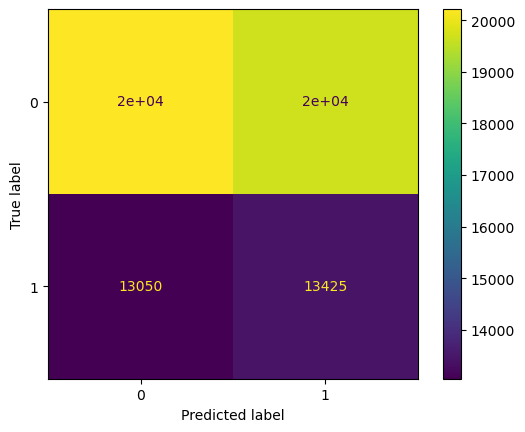

In [133]:
# confusion matrix for test
answers = xgb.predict(mdata_test_standard)

cm = confusion_matrix(answers,sgn_returns_ahead_test, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_test.values, xgb.predict(mdata_test_standard)))

### (d) MLP CLASSIFIER

#### quantile transformer

              precision    recall  f1-score   support

           0       0.51      0.69      0.59    132964
           1       0.52      0.34      0.41    132620

    accuracy                           0.51    265584
   macro avg       0.51      0.51      0.50    265584
weighted avg       0.51      0.51      0.50    265584



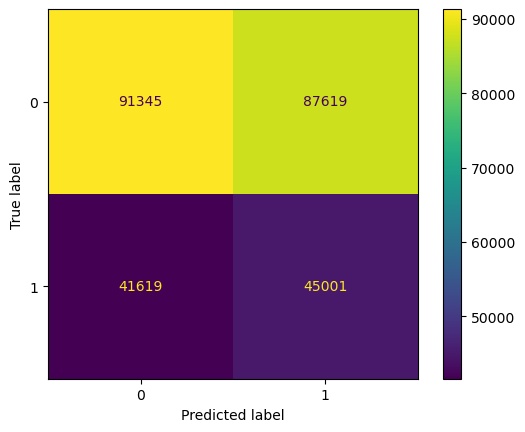

In [150]:
# confusion matrix for train
# {'identity', 'logistic', 'tanh', 'relu'}
mlp = MLPClassifier(hidden_layer_sizes=(20,20),activation='relu',random_state=random_state)
mlp.fit(mdata_train_quantile,sgn_returns_ahead_train)
answers = mlp.predict(mdata_train_quantile)

cm = confusion_matrix(answers,sgn_returns_ahead_train, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=mlp.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_train.values, mlp.predict(mdata_train_quantile)))

              precision    recall  f1-score   support

           0       0.51      0.69      0.59     33265
           1       0.52      0.34      0.41     33131

    accuracy                           0.51     66396
   macro avg       0.52      0.51      0.50     66396
weighted avg       0.52      0.51      0.50     66396



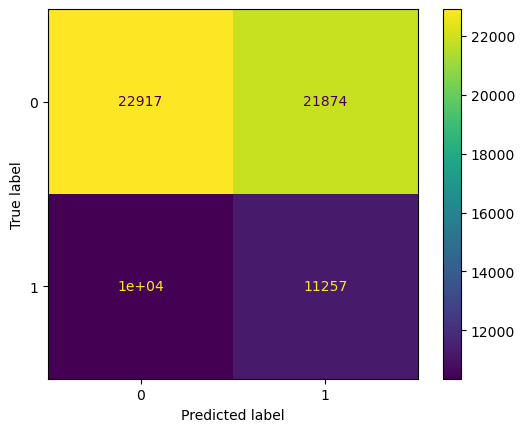

In [143]:
# confusion matrix for test
answers = mlp.predict(mdata_test_quantile)

cm = confusion_matrix(answers,sgn_returns_ahead_test, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=mlp.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_test.values, mlp.predict(mdata_test_quantile)))

#### standard transformer

              precision    recall  f1-score   support

           0       0.51      0.66      0.58    132964
           1       0.52      0.36      0.43    132620

    accuracy                           0.51    265584
   macro avg       0.52      0.51      0.50    265584
weighted avg       0.52      0.51      0.50    265584



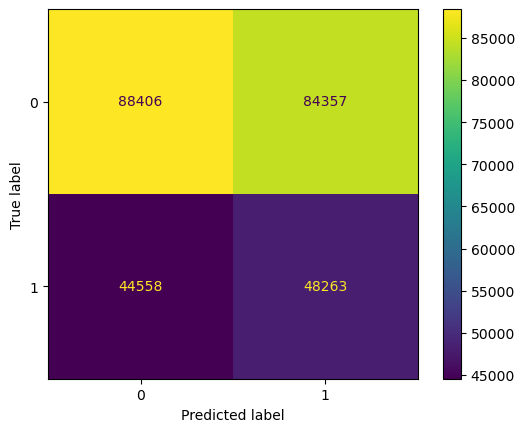

In [146]:
# confusion matrix for train
# {'identity', 'logistic', 'tanh', 'relu'}
mlp = MLPClassifier(hidden_layer_sizes=(20,20),activation='relu',random_state=random_state)
mlp.fit(mdata_train_standard,sgn_returns_ahead_train)
answers = mlp.predict(mdata_train_standard)

cm = confusion_matrix(answers,sgn_returns_ahead_train, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=mlp.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_train.values, mlp.predict(mdata_train_standard)))

              precision    recall  f1-score   support

           0       0.51      0.66      0.58     33265
           1       0.52      0.36      0.43     33131

    accuracy                           0.51     66396
   macro avg       0.51      0.51      0.50     66396
weighted avg       0.51      0.51      0.50     66396



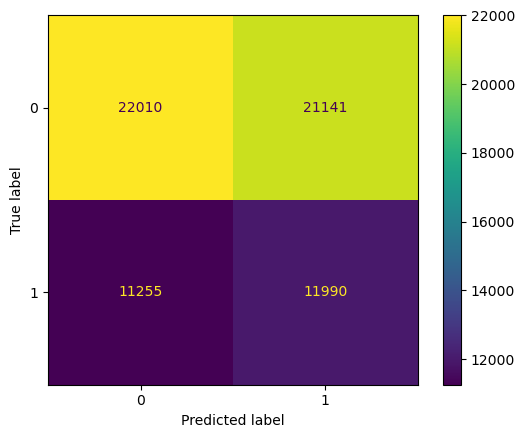

In [147]:
# confusion matrix for test
answers = mlp.predict(mdata_test_standard)

cm = confusion_matrix(answers,sgn_returns_ahead_test, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=mlp.classes_)
disp.plot()

print (classification_report(sgn_returns_ahead_test.values, mlp.predict(mdata_test_standard)))

### (e) COMPARE RESULTS

TEST SCORES:
1) DECISION TREE: TRAIN - (0.65, 0.54) | (0.65, 0.54), TEST - (0.67, 0.67) | (0.56, 0.43)
1) XGBOOST: TRAIN - (0.59, 0.49) | (0.59, 0.5), TEST - (0.56, 0.45) | (0.55, 0.45)
1) MLP: TRAIN - (0.59, 0.41) | (0.58, 0.43), TEST - (0.59, 0.41) | (0.58, 0.43)
_____
AS YOU CAN SEE THE BEST SCORE THE DECISION TREE METHOD DEMONSTRATES 
MOREOVER, THE RESULT IS ALSO STABLE TRAIN -> TEST (THERE IS OF COURSE 
PERFORMANCE DEGRADATION BUT STILL IT'S BETTER THAT OTHER METHODS)